## Maxout Networks in Pytorch 

This notebook is an implementation of maxout units (https://arxiv.org/abs/1302.4389) in Pytorch. My primary motivation of this was to ensure that I actually understood what maxout units were, as I found most explanations available quite opaque or incorrect! 

In [1]:
import numpy as np 
import torch 
import torch.nn as nn 
from torchvision import datasets, transforms 
from torch.autograd import Variable 
from torch.nn import init
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import seaborn as sns
%matplotlib inline 

Below we define a custom object so we can have models which contain objects which behave like lists while holding multiple modules. This is needed as we're going to store lists of layers per maxout unit. 

In [2]:
class ListModule(object):
    def __init__(self, module, prefix, *args):
        self.module = module
        self.prefix = prefix
        self.num_module = 0
        for new_module in args:
            self.append(new_module)

    def append(self, new_module):
        if not isinstance(new_module, nn.Module):
            raise ValueError('Not a Module')
        else:
            self.module.add_module(self.prefix + str(self.num_module), new_module)
            self.num_module += 1

    def __len__(self):
        return self.num_module

    def __getitem__(self, i):
        if i < 0 or i >= self.num_module:
            raise IndexError('Out of bound')
        return getattr(self.module, self.prefix + str(i))

In [3]:
learning_rate = 0.0001
batch_size = 50
n_epochs = 3
cuda = torch.cuda.is_available()

The magic normalization numbers below are actually the mean and the std of the training set of MNIST, hardcoded to save compute each run. 

In [5]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                       ])),
                       batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



In [7]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, download=True, 
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                       ])),
                       batch_size=batch_size, shuffle=True)

### What is Maxout? 
Maxout is a piece of a deep learning model that sits somewhere between an activation function and a layer. It computes a nonlinearity (namely the max function) but also has learnable parameters. For reference, it is generally considered an activation but I find that terminology troublesome as it forces there to be multiple layers to max over. `¯\_(ツ)_/¯`

In their paper, Goodfellow et. al. describe the maxout activation as: 

$$h_i = max_{j \in [1,k]} z_{i,j}$$

where $h_i$ is the hidden layer output and $z = x^TW_{\cdots i,j} + b_{i,j}$ , where $x$ could be the input or the output of the previous layer. 


I find this description incredibly confusing and for a while I thought that all that you did for maxout was to compute a linear layer, group into k groups, and take the max over those groups. (the use of $k$ in the indices above should give you a hint that this interpretation is wrong) Alas, Karpathy was to the rescue here: http://cs231n.github.io/neural-networks-1/

The tldr; is that a maxout unit is an element-wise max _over_ multiple linear (or convolutional/other) layers, so for a maxout layer with two units it is computed, like so: 
$max\{W_1^Tx +b_1, W_2^Tx + b_2\}$

so in the case where $W_2^Tx+b_2 = 0$ we see that the maxout layer is a ReLU. For other properties about maxout nets, we refer back to Goodfellow's paper. 

### Define Models 
Here we define the two classes of models to test the maxout network against. 

We have an MLP and ConvNet using just ReLU's and the maxout equivalent of those networks. 

Note that for each layer which uses a maxout we have $lu$ total parameters, where $l$ is the number of parameters per unit and $u$ is the number of units. 

In [8]:
class rectifier_mlp(nn.Module):
    def __init__(self):
        super(rectifier_mlp, self).__init__()
        self.fc1 = nn.Linear(784, 1024)
        self.fc2 = nn.Linear(1024, 10)


    def forward(self, x): 
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [9]:
class maxout_mlp(nn.Module):
    def __init__(self, num_units=2):
        super(maxout_mlp, self).__init__()
        self.fc1_list = ListModule(self, "fc1_")
        self.fc2_list = ListModule(self, "fc2_")
        for _ in range(num_units):
            self.fc1_list.append(nn.Linear(784, 1024))
            self.fc2_list.append(nn.Linear(1024, 10))

    def forward(self, x): 
        x = x.view(-1, 784)
        x = self.maxout(x, self.fc1_list)
        x = F.dropout(x, training=self.training)
        x = self.maxout(x, self.fc2_list)
        return F.log_softmax(x)

    def maxout(self, x, layer_list):
        max_output = layer_list[0](x)
        for _, layer in enumerate(layer_list, start=1):
            max_output = torch.max(max_output, layer(x))
        return max_output
                            

In [10]:
class rectifier_conv_net(nn.Module):
    def __init__(self):
        super(rectifier_conv_net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 5, padding=2)
        self.conv2 = nn.Conv2d(32, 64, 5, padding=2)
        self.fc1 = nn.Linear(64*7*7, 1024)
        self.fc2 = nn.Linear(1024, 10)


    def forward(self, x): 
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, 64*7*7)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [11]:
class maxout_conv_net(nn.Module):
    def __init__(self, num_units=2):
        super(maxout_conv_net, self).__init__()
        self.conv1_list = ListModule(self, "conv1_")
        self.conv2_list = ListModule(self, "conv2_")
        self.fc1_list = ListModule(self, "fc1_")
        self.fc2_list = ListModule(self, "fc2_")
        for _ in range(num_units):
            self.conv1_list.append(nn.Conv2d(1, 32, 5, padding=2))
            self.conv2_list.append(nn.Conv2d(32, 64, 5, padding=2))
            self.fc1_list.append(nn.Linear(64*7*7, 1024))
            self.fc2_list.append(nn.Linear(1024, 10))

    def forward(self, x): 
        x = F.max_pool2d(self.maxout(x, self.conv1_list), 2)
        x = F.max_pool2d(self.maxout(x, self.conv2_list), 2)
        x = x.view(-1, 64*7*7)
        x = self.maxout(x, self.fc1_list)
        x = F.dropout(x, training=self.training)
        x = self.maxout(x, self.fc2_list)
        return F.log_softmax(x)

    def maxout(self, x, layer_list):
        max_output = layer_list[0](x)
        for _, layer in enumerate(layer_list, start=1):
            max_output = torch.max(max_output, layer(x))
        return max_output
                            

In [15]:
def train(epoch,  net, train_loss, train_acc): 
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    net.train()
    for batch_idx, (data, target) in enumerate(train_loader): 
        if cuda:
            data, target = Variable(data).cuda(0), Variable(target).cuda(0)
        else:
            data, target = Variable(data), Variable(target)
            
        optimizer.zero_grad()
        output = net(data)
        loss = F.cross_entropy(output, target)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
        prediction = output.data.max(1)[1]
        accuracy = prediction.eq(target.data).sum()*1.0/batch_size*100.0 
        train_acc.append(accuracy)
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [16]:
def test(epoch, net):
    net.eval()
    test_loss = 0
    correct = 0
    for data, target in test_loader:
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data, volatile=True), Variable(target)
        output = net(data)
        test_loss += F.cross_entropy(output, target).item()
        pred = output.data.max(1)[1] # get the index of the max log-probability
        correct += pred.eq(target.data).cpu().sum()

    test_loss = test_loss
    test_loss /= len(test_loader) # loss function already averages over batch size
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [17]:
if cuda:
    net_relu = rectifier_conv_net().cuda()
else:
    net_relu = rectifier_conv_net()
relu_loss = [] 
relu_acc = []
for epoch in range(n_epochs): 
    train(epoch, net_relu, relu_loss, relu_acc)
    test(epoch, net_relu)

C:\Users\yasho\AppData\Local\Temp\ipykernel_116\3476879234.py:17: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.303015
Train Epoch: 0 [5000/60000 (8%)]	Loss: 0.419752
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.266622
Train Epoch: 0 [15000/60000 (25%)]	Loss: 0.145577
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.262069
Train Epoch: 0 [25000/60000 (42%)]	Loss: 0.123064
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.229677
Train Epoch: 0 [35000/60000 (58%)]	Loss: 0.118933
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.102190
Train Epoch: 0 [45000/60000 (75%)]	Loss: 0.067328
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.023033
Train Epoch: 0 [55000/60000 (92%)]	Loss: 0.042585


C:\Users\yasho\AppData\Local\Temp\ipykernel_116\1272325452.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)



Test set: Average loss: 0.0564, Accuracy: 9829/10000 (98%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.126205
Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.151101
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.046178
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.065658
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.025831
Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.033142
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.017649
Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.132626
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.011232
Train Epoch: 1 [45000/60000 (75%)]	Loss: 0.023515
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.019395
Train Epoch: 1 [55000/60000 (92%)]	Loss: 0.030575

Test set: Average loss: 0.0382, Accuracy: 9876/10000 (99%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.039112
Train Epoch: 2 [5000/60000 (8%)]	Loss: 0.057213
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.010218
Train Epoch: 2 [15000/60000 (25%)]	Loss: 0.016414
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.059671
Train Epoch: 2 [25000/60000 (42%)]	Loss: 0

In [18]:
if cuda:
    net_maxout = maxout_conv_net(num_units=5).cuda() #this uses 5 "maxout units" per "layer" 
else:
    net_maxout = maxout_conv_net(num_units=5)
maxout_loss = [] 
maxout_acc = []
for epoch in range(n_epochs): 
    train(epoch, net_maxout, maxout_loss, maxout_acc)
    test(epoch, net_maxout)

C:\Users\yasho\AppData\Local\Temp\ipykernel_116\3933911939.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.360898
Train Epoch: 0 [5000/60000 (8%)]	Loss: 0.307796
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.211857
Train Epoch: 0 [15000/60000 (25%)]	Loss: 0.097797
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.144156
Train Epoch: 0 [25000/60000 (42%)]	Loss: 0.104841
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.085498
Train Epoch: 0 [35000/60000 (58%)]	Loss: 0.174965
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.041148
Train Epoch: 0 [45000/60000 (75%)]	Loss: 0.222196
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.058747
Train Epoch: 0 [55000/60000 (92%)]	Loss: 0.025577


C:\Users\yasho\AppData\Local\Temp\ipykernel_116\1272325452.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)



Test set: Average loss: 0.0493, Accuracy: 9837/10000 (98%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.027061
Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.070990
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.024793
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.127609
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.028530
Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.011766
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.010946
Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.036566
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.008922
Train Epoch: 1 [45000/60000 (75%)]	Loss: 0.072018
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.112786
Train Epoch: 1 [55000/60000 (92%)]	Loss: 0.006450

Test set: Average loss: 0.0425, Accuracy: 9869/10000 (99%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.028124
Train Epoch: 2 [5000/60000 (8%)]	Loss: 0.028138
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.121977
Train Epoch: 2 [15000/60000 (25%)]	Loss: 0.007587
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.052519
Train Epoch: 2 [25000/60000 (42%)]	Loss: 0

In [14]:
if cuda:
    mlp_relu = rectifier_mlp().cuda() 
else:
    mlp_relu = rectifier_mlp()
relu_mlp_loss = [] 
relu_mlp_acc = []
for epoch in range(n_epochs): 
    train(epoch, mlp_relu, relu_mlp_loss, relu_mlp_acc)
    test(epoch, mlp_relu)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.348691
Train Epoch: 0 [5000/60000 (8%)]	Loss: 0.682529
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.646795
Train Epoch: 0 [15000/60000 (25%)]	Loss: 0.302137
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.265129
Train Epoch: 0 [25000/60000 (42%)]	Loss: 0.374851
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.476626
Train Epoch: 0 [35000/60000 (58%)]	Loss: 0.351321
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.422480
Train Epoch: 0 [45000/60000 (75%)]	Loss: 0.324298
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.330992
Train Epoch: 0 [55000/60000 (92%)]	Loss: 0.216023

Test set: Average loss: 0.2178, Accuracy: 9364/10000 (94%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.397623
Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.346569
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.124273
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.188086
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.086380
Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.271180
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.160728
Tra

In [19]:
if cuda:
    mlp_maxout = maxout_mlp(num_units=5).cuda() 
else:
    mlp_maxout = maxout_mlp(num_units=5)
maxout_mlp_loss = [] 
maxout_mlp_acc = []
for epoch in range(n_epochs): 
    train(epoch, mlp_maxout, maxout_mlp_loss, maxout_mlp_acc)
    test(epoch, mlp_maxout)

Train Epoch: 0 [0/60000 (0%)]	Loss: 2.452453


C:\Users\yasho\AppData\Local\Temp\ipykernel_116\4226546613.py:15: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 0 [5000/60000 (8%)]	Loss: 0.459581
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.370488
Train Epoch: 0 [15000/60000 (25%)]	Loss: 0.156213
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.199699
Train Epoch: 0 [25000/60000 (42%)]	Loss: 0.149305
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.135788
Train Epoch: 0 [35000/60000 (58%)]	Loss: 0.302234
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.089232
Train Epoch: 0 [45000/60000 (75%)]	Loss: 0.233280
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.160067
Train Epoch: 0 [55000/60000 (92%)]	Loss: 0.128705


C:\Users\yasho\AppData\Local\Temp\ipykernel_116\1272325452.py:8: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  data, target = Variable(data, volatile=True), Variable(target)



Test set: Average loss: 0.1384, Accuracy: 9600/10000 (96%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.174342
Train Epoch: 1 [5000/60000 (8%)]	Loss: 0.178904
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.155739
Train Epoch: 1 [15000/60000 (25%)]	Loss: 0.118325
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.082263
Train Epoch: 1 [25000/60000 (42%)]	Loss: 0.117883
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.197321
Train Epoch: 1 [35000/60000 (58%)]	Loss: 0.059323
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.127476
Train Epoch: 1 [45000/60000 (75%)]	Loss: 0.134717
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.253097
Train Epoch: 1 [55000/60000 (92%)]	Loss: 0.157242

Test set: Average loss: 0.0932, Accuracy: 9731/10000 (97%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.027247
Train Epoch: 2 [5000/60000 (8%)]	Loss: 0.192539
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.042914
Train Epoch: 2 [15000/60000 (25%)]	Loss: 0.062732
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.074999
Train Epoch: 2 [25000/60000 (42%)]	Loss: 0

## Plots! 
Here I show the accuracy and loss of both the MLP and the ConvNet versions of the ReLU and maxout nets. 

These plots aren't incredibly informative as MNIST is so easy that both nets do very well quickly. That said, it is clear from the plots and numbers above that the maxout network is doing better than the ReLU net. 

NameError: name 'relu_mlp_loss' is not defined

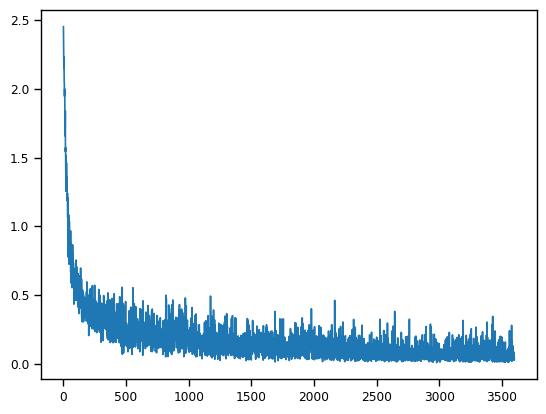

In [20]:
sns.set_context("paper")
plot1, = plt.plot(maxout_mlp_loss, label='maxout_mlp')
plot2, = plt.plot(relu_mlp_loss, label='relu_mlp')
plt.legend(handles=[plot1, plot2])


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

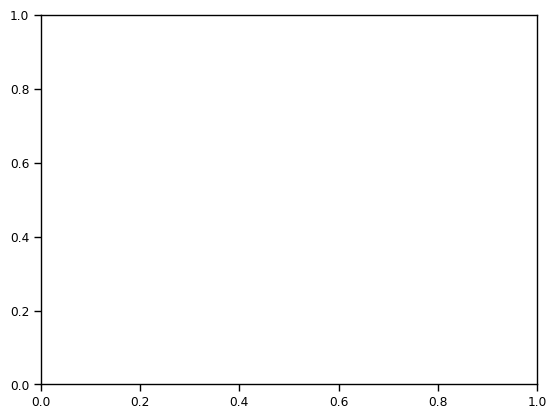

In [21]:
plot1, = plt.plot(np.arange(len(maxout_mlp_acc)), maxout_mlp_acc, label='maxout_conv')
plot2, = plt.plot(np.arange(len(relu_mlp_acc)), relu_mlp_acc, label='relu_conv')
plt.legend(handles=[plot1, plot2])


## Conclusion 

Maxout units are cool! I'm interested to see how much of an improvement these make on lower dimensional linear layers at the end of large convolutional nets and will be testing that in the coming weeks. The lack of saturation might help gradients back prop, while not requiring that you have many times more parameters for you entire model. 

This work also made me realize viscerally how important clear explanations are! There are *so many* incorrect implementations that you can find online of maxout units, so hopefully this will serve as a guide for people who were in my position a couple of days ago. 

### References 
- https://arxiv.org/pdf/1302.4389.pdf (original paper) 
- http://cs231n.github.io/neural-networks-1/ (Karpathy to the rescue)
- http://www.simon-hohberg.de/2015/07/19/maxout.html (really helpful visualizations) 
- tons of Pytorch forum posts, thanks y'all 